# Machine Learning project a.y. 2021/2022

## Scikit-learn MLP model

## Importing libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ast

from sklearn.base import clone as clone_model
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from scipy.stats import uniform
from scipy.stats import randint
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingRegressor
from dataclasses import dataclass

## Loading training set and blind test set

In [2]:
df_visual = pd.read_csv('./data/ML-CUP21-TR.csv', usecols=[11,12], names=['idx','f1','f2','f3','f4','f5','f6','f7','f8','f9','f10', 'x','y'])
df_task_tr = pd.read_csv('./data/ML-CUP21-TR.csv', names=['idx','f1','f2','f3','f4','f5','f6','f7','f8','f9','f10', 'x','y'])
df_task_tr = df_task_tr[7:] # remove first 7 rows of comments
df_visual = df_visual[7:]

df_blind_ts = pd.read_csv('./data/ML-CUP21-TS.csv', names=['idx','f1','f2','f3','f4','f5','f6','f7','f8','f9','f10'])
df_blind_ts = df_blind_ts[7:]
df_blind_ts.drop(labels="idx", axis=1, inplace=True)
blind_ts = df_blind_ts.values

## Evaluation metrics

We define the <b>MEE (Mean Euclidean Error)</b> function which is used to evaluate the mean euclidean distance between two points with x and y coordinates.
The function takes in input the true target and the predicted target and yields a floating point number which represents the performance. 

In [3]:
def mee(true_target, predicted_target): #assuming target is 2-dim matrix with x and y as columns
    l = true_target.shape[0]
    res = 0
    
    for p in range(l): #for p-th pattern in l (number of samples)
        x_diff = np.square(true_target[p,0] - predicted_target[p,0]) #difference between the x value of the true and predicted target
        y_diff = np.square(true_target[p,1] - predicted_target[p,1]) #difference between the y values of true and predicted target
        sum_term = x_diff + y_diff
        res = res + np.sqrt(sum_term)
    res = res / l
    
    #return np.average([np.sqrt(np.square(true_target[p,0] - predicted_target[p,0]) + np.square(true_target[p,1] - predicted_target[p,1])) for p in range(l)]) #compact form
    return res

We also define a random state (seed) to allow reproducibility on our experiments

In [4]:
RS_NUMBER = 69

## Regression task

### Preparing the training set

In [5]:
df_task_tr.drop(labels="idx", axis=1, inplace=True)

In [6]:
y = df_task_tr[['x','y']].values
X = df_task_tr.drop(labels=['x','y'], axis=1).values
X_all = X
y_all = y

In [7]:
print(X.shape)
print(y.shape)

(1477, 10)
(1477, 2)


### Internal Test set
We split the data set obtaining an internal test set (10%), we will use this internal test at the end to test internally the generalization error

In [8]:
X, X_internal_test, y, y_internal_test = train_test_split(X, y, test_size=0.1, random_state=RS_NUMBER)
print(f"X shape: {X.shape}")
print(f"X internal test shape: {X_internal_test.shape}")
print(f"y shape: {y.shape}")
print(f"y internal test shape: {y_internal_test.shape}")

X shape: (1329, 10)
X internal test shape: (148, 10)
y shape: (1329, 2)
y internal test shape: (148, 2)


In [9]:
#trains the model with one iteration (epoch) and computes in output a list of train and test scores using MEE
def fit_and_score(epochs, eval_model, X_train, y_train, X_test, y_test):
    train_scores = []
    test_scores = []
    train_loss = []
    test_loss = []
    for i in range(epochs):
        eval_model = eval_model.partial_fit(X_train,y_train)
        y_train_predicted = eval_model.predict(X_train)
        y_test_predicted = eval_model.predict(X_test)
        #results on train set
        train_scores.append(mean_squared_error(y_train, y_train_predicted))
        test_scores.append(mean_squared_error(y_test, y_test_predicted))
        #result on test set
        train_loss.append(mee(y_train, y_train_predicted))
        test_loss.append(mee(y_test, y_test_predicted))
    return train_scores, test_scores, train_loss, test_loss


## Randomized Search

In [10]:
# define the number of iterations
n_iter_search = 1000
# define number of k-folds
k = 10

In [11]:
%%script false --no-raise-error

# to find the best set of parameter setting, we can run a randomized search

# define the parameters' values
params = {
    "hidden_layer_sizes": [
        (5,),(10,),(25,),(50,),(100,),
        (5, 5),(10, 10),(25, 25),(50, 50),(100, 100),],
    "activation" : ["logistic", "tanh", "relu"],
    "solver": ["sgd"],
    "learning_rate": ["constant", "adaptive", "invscaling"],
    "learning_rate_init": uniform(0.01, 0.5),
    "alpha": uniform(0.0001, 0.1),
    "momentum": [0.1, 0.3, 0.5, 0.7, 0.9, 1],
    "batch_size": randint(1, X.shape[0]),
    "n_iter_no_change": [5,15,25],
    "random_state": [RS_NUMBER],
    "tol": uniform(0.001,0.0001),
    "early_stopping": [True],
    "validation_fraction": [0.2],
    "max_iter": [5000],
}

# define the grid search
rand_gs = RandomizedSearchCV(
    MLPRegressor(),
    param_distributions=params,
    n_iter=n_iter_search,
    n_jobs=-1,
    scoring=make_scorer(mee), #scoring is based on the highest value
    cv=k,
    random_state=RS_NUMBER,
    verbose=10
)
# run the grid search
rand_gs.fit(X, y)


In [12]:
%%script false --no-raise-error

df_results = pd.DataFrame(data=rand_gs.cv_results_) #trasform into a pandas dataframe
df_results.sort_values(by="rank_test_score", axis=0, ascending=False, inplace=True) #sort rank values in decreasing order 
df_results.dropna(inplace=True) #delete nan values 
df_results = df_results[:50] #keep only top 50 models
pd.DataFrame.to_csv(df_results, "sklearn_results/rand1_search.csv")

In [13]:
df_results = pd.read_csv("sklearn_results/rand1_search.csv")
df_results.head()


,Unnamed: 0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_alpha,param_batch_size,param_early_stopping,param_hidden_layer_sizes,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,409,1.306419,0.101278,0.002148,0.000790,logistic,0.066381,65,True,"(10, 10)",...,1.253411,1.214005,1.258232,1.172745,1.106796,1.239143,1.112964,1.169361,0.066677,749
1,379,3.527179,0.929324,0.001601,0.000414,logistic,0.077525,78,True,"(5, 5)",...,1.227494,1.243120,1.259606,1.165110,1.093853,1.240227,1.131467,1.172682,0.068925,748
2,629,0.843163,0.188665,0.001761,0.000416,logistic,0.073977,130,True,"(10, 10)",...,1.225236,1.229386,1.277292,1.186669,1.123846,1.196943,1.062257,1.173067,0.065178,747
3,389,3.011471,0.359548,0.007350,0.015625,tanh,0.052900,121,True,"(25, 25)",...,1.262292,1.227956,1.268792,1.192865,1.108617,1.294039,1.042950,1.178071,0.086018,746
4,957,6.348539,1.324228,0.007037,0.015659,logistic,0.070135,18,True,"(25,)",...,1.259987,1.226636,1.276441,1.206872,1.109764,1.258349,1.061662,1.181657,0.075615,745


In [14]:
#get the best params for the grid search (cannot use rand_gs.best_estimator directly since it will yield the worst estimator based on MEE)
best_params = df_results['params'][0]
print(f"Mean error on the {k}-folds (MEE) on best model: {df_results['mean_test_score'][0]}\n")
print(f"Best params: {best_params}")

Mean error on the 10-folds (MEE) on best model: 1.1693608922512977

Best params: {'activation': 'logistic', 'alpha': 0.06638057704087998, 'batch_size': 65, 'early_stopping': True, 'hidden_layer_sizes': (10, 10), 'learning_rate': 'constant', 'learning_rate_init': 0.06110060201246525, 'max_iter': 5000, 'momentum': 0.5, 'n_iter_no_change': 25, 'random_state': 69, 'solver': 'sgd', 'tol': 0.001011116996715985, 'validation_fraction': 0.2}


In [15]:
@dataclass
class GridSearchRanges:
    '''Class of keeping track of the min and max values for the hyperparameters tuning'''
    
    hidden_range = []
    min_lr_init = 0
    max_lr_init = 0
    min_alpha = 0
    max_alpha = 0
    min_bs = 0
    max_bs = 0
    n_iter_no_change = []
    min_tol = 0
    max_tol = 0
    min_momentum = 0
    max_momentum = 0
    
    def set_ranges(self):

        self.hidden_range = np.unique(df_results['param_hidden_layer_sizes'])
        self.hidden_range = self.hidden_range.ravel() #convert to array
        print(self.hidden_range)

        self.min_lr_init = np.min(df_results['param_learning_rate_init'])
        self.max_lr_init = np.max(df_results['param_learning_rate_init'])
        print(f"LR: [{self.min_lr_init}, {self.max_lr_init}]")

        self.min_alpha = np.min(df_results['param_alpha'])
        self.max_alpha = np.max(df_results['param_alpha'])
        print(f"alpha: [{self.min_alpha}, {self.max_alpha}]")

        self.min_bs = np.min(df_results['param_batch_size'])
        self.max_bs = np.max(df_results['param_batch_size'])
        print(f"BATCH: [{self.min_bs}, {self.max_bs}]")

        self.n_iter_no_change_range = np.unique(df_results['param_n_iter_no_change'])
        self.n_iter_no_change_range = self.n_iter_no_change_range.ravel()
        print(f"n_iter_no_change: {self.n_iter_no_change_range}")

        self.min_tol = np.min(df_results['param_tol'])
        self.max_tol = np.max(df_results['param_tol'])
        print(f"TOL: [{self.min_tol}, {self.max_tol}]")
    
        self.min_momentum = np.min(df_results['param_momentum'])
        self.max_momentum = np.max(df_results['param_momentum'])
        print(f"MOMENTUM: [{self.min_momentum}, {self.max_momentum}]")
    
    

In [16]:
gs = GridSearchRanges()
gs.set_ranges()
gs.hidden_range = [ast.literal_eval(x) for x in gs.hidden_range]

['(10, 10)' '(10,)' '(25, 25)' '(25,)' '(5, 5)' '(5,)' '(50, 50)' '(50,)']
LR: [0.0106165473559543, 0.3874715705725129]
alpha: [0.0002297504583553, 0.0973957203436703]
BATCH: [18, 1272]
n_iter_no_change: [ 5 15 25]
TOL: [0.0010007827399257, 0.0010940800112094]
MOMENTUM: [0.1, 0.9]


### Second Randomized Search using min e max values

In [17]:
%%script false --no-raise-error

# define the parameters values
params = {
    "hidden_layer_sizes": gs.hidden_range,
    "activation" : ["logistic", "tanh"],
    "solver": ["sgd", "adam"],
    "learning_rate": ["adaptive", "invscaling"],
    "learning_rate_init": uniform(gs.min_lr_init, gs.max_lr_init),
    "alpha": uniform(gs.min_alpha, gs.max_alpha),
    "batch_size": randint(gs.min_bs, gs.max_bs),
    "n_iter_no_change": [5, 15, 25],
    "momentum": uniform(gs.min_momentum, gs.max_momentum),
    "random_state": [RS_NUMBER],
    "tol": uniform(gs.min_tol,gs.max_tol),
    "early_stopping": [True],
    "validation_fraction": [0.2],
    "max_iter": [5000],
}

# define the grid search
rand_gs = RandomizedSearchCV(
    MLPRegressor(),
    param_distributions=params,
    n_iter=n_iter_search,
    n_jobs=-1,
    scoring=make_scorer(mee), #scoring is based on the highest value
    cv=k,
    random_state = RS_NUMBER,
    verbose=10,
)
# run the grid search
rand_gs.fit(X, y)


In [18]:
%%script false --no-raise-error

df_results = pd.DataFrame(data=rand_gs.cv_results_) #trasform into a pandas dataframe
df_results.sort_values(by="rank_test_score", axis=0, ascending=False, inplace=True) #sort rank values in decreasing order 
df_results.dropna(inplace=True) #delete nan values 
df_results = df_results[:50] #keep only top 50 models
pd.DataFrame.to_csv(df_results, "sklearn_results/rand2_search.csv")

In [19]:
df_results = pd.read_csv("sklearn_results/rand2_search.csv")
df_results.head()

,Unnamed: 0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_alpha,param_batch_size,param_early_stopping,param_hidden_layer_sizes,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,672,0.570138,0.084119,0.003995,0.008377,logistic,0.069912,854,True,"(25, 25)",...,1.177998,1.163557,1.249796,1.158815,1.081662,1.217832,1.074917,1.129181,0.076160,993
1,120,0.431352,0.037372,0.003720,0.007066,logistic,0.087508,138,True,"(25, 25)",...,1.176305,1.218488,1.248914,1.111385,1.089464,1.234966,1.040058,1.138351,0.088791,992
2,997,0.296068,0.030336,0.001251,0.000107,logistic,0.089680,260,True,"(25, 25)",...,1.208696,1.215252,1.266178,1.154304,1.106841,1.204711,1.014951,1.142147,0.086179,991
3,524,0.706179,0.121536,0.001441,0.000300,logistic,0.074875,512,True,"(50, 50)",...,1.263384,1.229693,1.244069,1.114423,1.124070,1.227517,1.085174,1.148766,0.080462,990
4,80,0.455462,0.055017,0.001243,0.000084,logistic,0.014247,667,True,"(25, 25)",...,1.277072,1.243844,1.259500,1.156721,1.092252,1.240421,1.076738,1.154516,0.092620,989


In [20]:
#get the best params for the grid search (cannot use rand_gs.best_estimator directly since it will yield the worst estimator based on MEE)
best_params = df_results['params'][0]
print(f"Mean error on the {k}-folds (MEE) on best model: {df_results['mean_test_score'][0]}\n")
print(f"Best params: {best_params}")

Mean error on the 10-folds (MEE) on best model: 1.1291809654972635

Best params: {'activation': 'logistic', 'alpha': 0.06991153037944176, 'batch_size': 854, 'early_stopping': True, 'hidden_layer_sizes': (25, 25), 'learning_rate': 'adaptive', 'learning_rate_init': 0.07787730717590882, 'max_iter': 5000, 'momentum': 0.2175465877496915, 'n_iter_no_change': 25, 'random_state': 69, 'solver': 'adam', 'tol': 0.001306792017296597, 'validation_fraction': 0.2}


We save the top 10 best models for later

In [21]:
best_models = list() #list of the top ten models of the final randomized search

for i in range(10):
    best_params_i = df_results['params'][i]
    best_params_i = ast.literal_eval(best_params_i)
    best_params_i['early_stopping'] = False
    model_i = MLPRegressor(**best_params_i)
    model_i_eval = MLPRegressor(**best_params_i)
    best_models.append(model_i)

In [22]:
best_params = ast.literal_eval(best_params)

In [23]:
model = MLPRegressor(**best_params)
best_params['early_stopping'] = False
eval_model = MLPRegressor(**best_params) #unfitted model used for evaluation
model.fit(X, y)

MLPRegressor(activation='logistic', alpha=0.06991153037944176, batch_size=854,
             early_stopping=True, hidden_layer_sizes=(25, 25),
             learning_rate='adaptive', learning_rate_init=0.07787730717590882,
             max_iter=5000, momentum=0.2175465877496915, n_iter_no_change=25,
             random_state=69, tol=0.001306792017296597,
             validation_fraction=0.2)

In [24]:
y_predicted = model.predict(X)
print(f"Accuracy: {model.score(X, y)}")
print(f"MEE: {mee(y, y_predicted)}")

Accuracy: 0.947087691512623
MEE: 1.0896898075653432


In [25]:
y_predicted_internal = model.predict(X_internal_test)
print(f"Accuracy: {model.score(X_internal_test, y_internal_test)}")
print(f"MEE: {mee(y_internal_test, y_predicted_internal)}")

Accuracy: 0.9355211375930804
MEE: 1.112846896635994


In [26]:
train_scores, test_scores, train_loss, test_loss = fit_and_score(model.n_iter_, eval_model, X, y, X_internal_test, y_internal_test)

In [28]:
def plot_learning_curves(train_scores, test_scores, epochs, y_label):
    plt.figure(figsize=(10,8))
    plt.plot(range(0,epochs), train_scores, label = "Training error", linestyle='dashed')
    plt.plot(range(0,epochs), test_scores, label = "Test error")
    plt.legend()
    plt.ylabel(y_label)
    plt.xlabel('Epoch');

 ## Loss Curves on best model

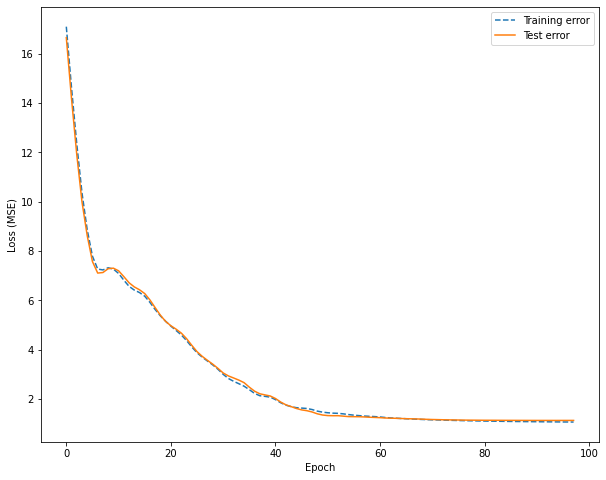

In [29]:
plot_learning_curves(train_loss, test_loss, model.n_iter_, "Loss (MSE)")

## Learning Curves on best model

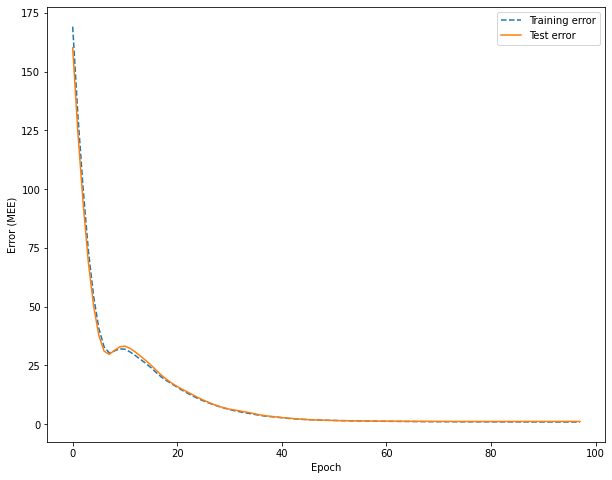

In [30]:
plot_learning_curves(train_scores, test_scores, model.n_iter_, "Error (MEE)")

### Plot of coordinates x and y from the training set

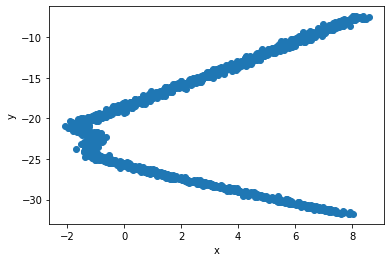

In [31]:
plt.xlabel("x")
plt.ylabel("y")
plt.scatter(df_visual['x'], df_visual['y'])

In [32]:
def plot_coordinates(model, X, true_y = None):
    y_predicted = model.predict(X)
    y_predicted = pd.DataFrame(data=y_predicted, columns=["x", "y"])
    if not None:
        true_y = pd.DataFrame(data=true_y, columns=["x", "y"])
        plt.scatter(true_y['x'], true_y['y'], c='r', marker='*')
    plt.xlabel("x")
    plt.ylabel("y")
    plt.scatter(y_predicted['x'], y_predicted['y'], c='#1f77b4')


### Predicted points on internal test set

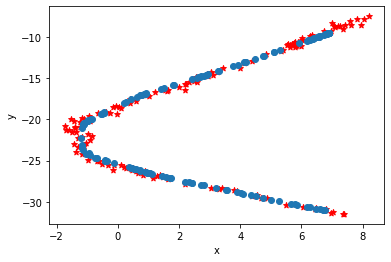

In [33]:
plot_coordinates(model, X_internal_test, y_internal_test)

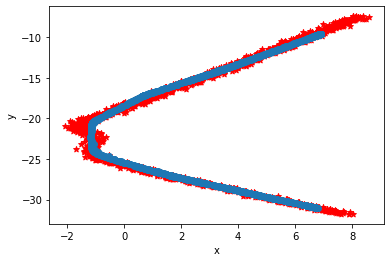

In [34]:
plot_coordinates(model, X_all, y_all)

### Predicted points on blind test set

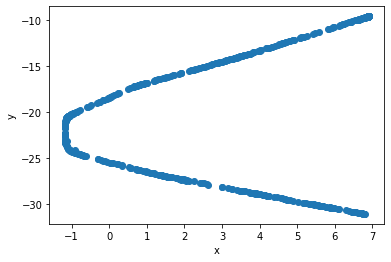

In [35]:
plot_coordinates(model, blind_ts)

## Ensemble 

First we try using the bagging method with 10 estimators.

In [36]:
bagging_ens = BaggingRegressor(model, n_estimators=10, n_jobs=-1, random_state=RS_NUMBER).fit(X, y)

In [37]:
y_predicted_internal_ensemble = bagging_ens.predict(X_internal_test)
print(f"Accuracy: {model.score(X_internal_test, y_internal_test)}")
print(f"MEE: {mee(y_internal_test, y_predicted_internal_ensemble)}")

Accuracy: 0.9355211375930804
MEE: 1.1382838619048485


Then we try the voting method using the 10 best models from the randomized search. 

In [38]:
y_predictions_internal_test = list()
y_predictions_blind_test = list()
epochs_best_models = list()

#fit every model
for model in best_models:
    model.fit(X,y)
    epochs_best_models.append(model.n_iter_)


#predictions on every model is averaged
for model in best_models:
    y_pred = model.predict(X_internal_test)
    y_predictions_internal_test.append(y_pred)
    y_pred = model.predict(blind_ts)
    y_predictions_blind_test.append(y_pred)


In [39]:
y_pred_voting_ens_internal_test = np.average(y_predictions_internal_test, axis=0)
y_pred_voting_ens_blind_test = np.average(y_predictions_blind_test, axis=0)

print(f"MEE: {mee(y_internal_test, y_pred_voting_ens_internal_test)}")

MEE: 1.0715401961400552


### Predicted points on internal test set using ensemble

#### BAGGING ENSEMBLE

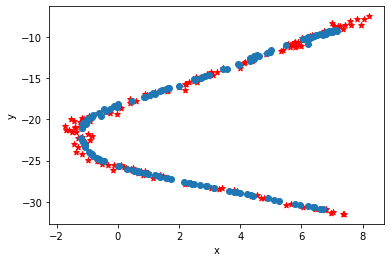

In [40]:
#BAGGING ENSEMBLE
plot_coordinates(bagging_ens, X_internal_test, y_internal_test)

#### VOTING COMMITEE OF 10 BEST MODELS

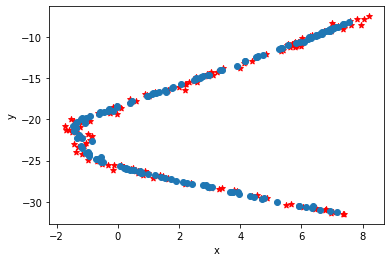

In [41]:
y_predicted = pd.DataFrame(data=y_pred_voting_ens_internal_test, columns=["x", "y"])
true_y = pd.DataFrame(data=y_internal_test, columns=["x", "y"])
plt.scatter(true_y['x'], true_y['y'], c='r', marker='*')
plt.xlabel("x")
plt.ylabel("y")
plt.scatter(y_predicted['x'], y_predicted['y'], c='#1f77b4');

### Predicted points on blind test set using Ensemble

#### BAGGING ENSEMBLE

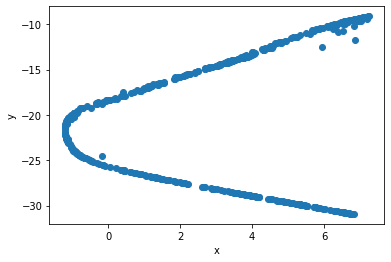

In [42]:
#BAGGING ENSEMBLE
plot_coordinates(bagging_ens, blind_ts)

#### VOTING COMMITEE OF 10 BEST MODELS

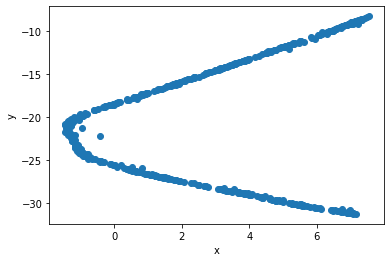

In [43]:
y_predicted = pd.DataFrame(data=y_pred_voting_ens_blind_test, columns=["x", "y"])
plt.xlabel("x")
plt.ylabel("y")
plt.scatter(y_predicted['x'], y_predicted['y'], c='#1f77b4');

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d9d840c9-75b3-4185-bb01-105f5cca8d83' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>